In [ ]:
#@title Run to install MuJoCo and `dm_control`
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

print('Installing dm_control...')
!pip install -q dm_control>=1.0.18

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

Installing dm_control...
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Installed dm_control 1.0.18


In [ ]:
print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del suite, env, pixels

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

Checking that the dm_control installation succeeded...
Installed dm_control 1.0.18


In [ ]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [ ]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

In [ ]:
from dm_control import suite
import PIL.Image
import numpy as np

duration = 40    # (seconds)
framerate = 30  # (Hz)

# Load one task:
#env = suite.load(domain_name="stacker", task_name = "stack_2")#, task_name="swingup")
#env = suite.load(domain_name="swimmer", task_name = "swimmer6")#, task_name="swingup")
env = suite.load(domain_name="dog", task_name = "run")#, task_name="swingup")
env.reset()
#env.render()
pixels = env.physics.render()

#display(PIL.Image.fromarray(pixels))

# Simulate and display video.
frames = []
env.reset()  # Reset state and time

for i in range(duration*framerate):
  action_spec = env.action_spec()
  action = np.random.uniform(action_spec.minimum,
                             action_spec.maximum,
                             size=action_spec.shape)
  env.step(action)
  pixels = env.physics.render(camera_id=0)#scene_option=scene_option)

  frames.append(pixels)

display_video(frames, framerate)

In [ ]:
class Leg(object):
  """A 2-DoF leg with position actuators."""
  def __init__(self, length, rgba):
    self.model = mjcf.RootElement()

    # Defaults:
    self.model.default.joint.damping = 2
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba  # Continued below...

    # Thigh:
    self.thigh = self.model.worldbody.add('body')
    self.hip = self.thigh.add('joint', axis=[0, 0, 1])
    self.thigh.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/4])

    # Hip:
    self.shin = self.thigh.add('body', pos=[length, 0, 0])
    self.knee = self.shin.add('joint', axis=[0, 1, 0])
    self.shin.add('geom', fromto=[0, 0, 0, 0, 0, -length], size=[length/5])

    # Position actuators:
    self.model.actuator.add('position', joint=self.hip, kp=10)
    self.model.actuator.add('position', joint=self.knee, kp=10)

In [ ]:
BODY_RADIUS = 0.1
BODY_SIZE = (BODY_RADIUS, BODY_RADIUS, BODY_RADIUS / 2)
random_state = np.random.RandomState(42)

def make_creature(num_legs):
  """Constructs a creature with `num_legs` legs."""
  rgba = random_state.uniform([0, 0, 0, 1], [1, 1, 1, 1])
  model = mjcf.RootElement()
  model.compiler.angle = 'radian'  # Use radians.

  # Make the torso geom.
  model.worldbody.add(
      'geom', name='torso', type='ellipsoid', size=BODY_SIZE, rgba=rgba)

  # Attach legs to equidistant sites on the circumference.
  for i in range(num_legs):
    theta = 2 * i * np.pi / num_legs
    hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta), 0])
    hip_site = model.worldbody.add('site', pos=hip_pos, euler=[0, 0, theta])
    leg = Leg(length=BODY_RADIUS, rgba=rgba)
    hip_site.attach(leg.model)

  return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


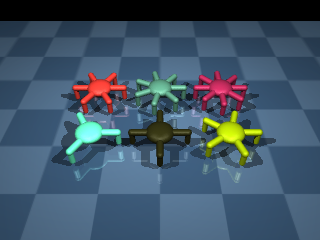

In [ ]:
#@title Six Creatures on a floor.{vertical-output: true}

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])

# Instantiate 6 creatures with 3 to 8 legs.
creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]

# Place them on a grid in the arena.
height = .15
grid = 5 * BODY_RADIUS
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])
for i, model in enumerate(creatures):
  # Place spawn sites on a grid.
  spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
  spawn_site = arena.worldbody.add('site', pos=spawn_pos, group=3)
  # Attach to the arena at the spawn sites, with a free joint.
  spawn_site.attach(model).add('freejoint')

# Instantiate the physics and render.
physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())

In [ ]:
#@title Video of the movement{vertical-output: true}
#@test {"timeout": 600}

duration = 10   # (Seconds)
framerate = 30  # (Hz)
video = []
pos_x = []
pos_y = []
torsos = []  # List of torso geom elements.
actuators = []  # List of actuator elements.
for creature in creatures:
  torsos.append(creature.find('geom', 'torso'))
  actuators.extend(creature.find_all('actuator'))

# Control signal frequency, phase, amplitude.
freq = 5
phase = 2 * np.pi * random_state.rand(len(actuators))
amp = 0.9

# Simulate, saving video frames and torso locations.
physics.reset()
while physics.data.time < duration:
  # Inject controls and step the physics.
  physics.bind(actuators).ctrl = amp * np.sin(freq * physics.data.time + phase)
  physics.step()

  # Save torso horizontal positions using bind().
  pos_x.append(physics.bind(torsos).xpos[:, 0].copy())
  pos_y.append(physics.bind(torsos).xpos[:, 1].copy())

  # Save video frames.
  if len(video) < physics.data.time * framerate:
    pixels = physics.render()
    video.append(pixels.copy())

display_video(video, framerate)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


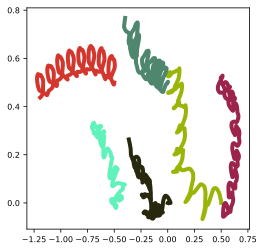

In [ ]:
creature_colors = physics.bind(torsos).rgba[:, :3]
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(color=creature_colors)
_ = ax.plot(pos_x, pos_y, linewidth=4)

In [ ]:
#@title A position controlled `cmu_humanoid`

walker = cmu_humanoid.CMUHumanoidPositionControlledV2020(
    observable_options={'egocentric_camera': dict(enabled=True)})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title A corridor arena with wall obstacles

arena = corridor_arenas.WallsCorridor(
    wall_gap=3.,
    wall_width=distributions.Uniform(2., 3.),
    wall_height=distributions.Uniform(2.5, 3.5),
    corridor_width=4.,
    corridor_length=30.,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title A task to navigate the arena

task = corridor_tasks.RunThroughCorridor(
    walker=walker,
    arena=arena,
    walker_spawn_position=(0.5, 0, 0),
    target_velocity=3.0,
    physics_timestep=0.005,
    control_timestep=0.03,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


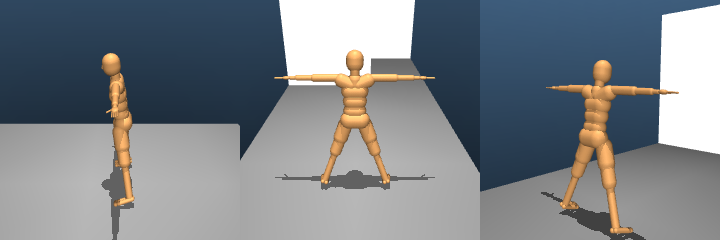

In [ ]:
#@title The `RunThroughCorridor` environment

env = composer.Environment(
    task=task,
    time_limit=10,
    random_state=np.random.RandomState(42),
    strip_singleton_obs_buffer_dim=True,
)
env.reset()
pixels = []
for camera_id in range(3):
  pixels.append(env.physics.render(camera_id=camera_id, width=240))
PIL.Image.fromarray(np.hstack(pixels))